# Heat Equation

Let us consider measured data collected from the solution to the heat equation, i.e.

$    \frac{\partial f}{\partial t} + D \,\frac{\partial^2 f}{\partial x^2} = 0, $

with $D = -1$. The data is constructed using the Finite Difference method with initial condition $f(x, 0) = 5\sin(2 \pi x)x(x-L)$ and a mesh with $N_x=100$ nodes in $x$ covering the domain $\Omega = [0,L]$ with $L=1$ and $N_t=100$ steps in $t$ with final time $T=N_t \Delta t$ where $\Delta t = 0.05 \Delta x^2/(1+|D|)$ is the step size and $\Delta x=L/N_x$ is the mesh size in $x$.

First, import the needed libraries:

In [4]:
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
sys.path.append(src_path)
from adjoint import *
size = 6
cm = 0.393701

## Generate Data

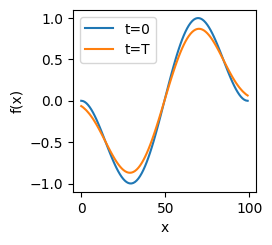

In [17]:
## generate data
# df/dt + D d2f/dx^2 = 0

CFL = 0.05
def dt_cfl(dx, D_m):
    # dt of simulation should be set satisfying CFL condition for stability
    return CFL*dx**2/(1.+abs(D_m))
    
def heat_equation(D_m, f0_m, dx_m, dt_m, Nt_m):
    f_m = np.zeros((Nt_m, len(f0_m)))
    f_m[0,:] = f0_m
    for i in range(Nt_m-1):
        f_m[i+1,:] = f_m[i,:] - D_m * np.gradient(np.gradient(f_m[i,:]))/dx_m**2 * dt_m
    return f_m

L = 1.0  # Length of the domain
Nx = 100  # Number of spatial grid points
D_ex = -1.0  # Thermal diffusivity

dx = L/Nx
dt = dt_cfl(dx, D_ex)
Nt = 1000
T = dt*Nt

# Initial condition
x =  np.linspace(0, L, Nx)
f0 = 5.*np.sin(2.* np.pi * x)*x*(x-L)
fs = heat_equation(D_ex, f0, dx, dt, Nt) #*np.random.normal(0.,0.001,(Nt,Nx)) # (Nt, Nx)

dx = np.array([dx])
x = np.array([x])
f0 = np.array([f0])
fs = np.array([fs])

plt.figure(figsize=(size*cm, size*cm))
plt.plot(fs[0,0,:], label="t=0")
plt.plot(fs[0,-1,:], label="t=T")
plt.legend()
plt.ylabel(r'f(x)')
plt.xlabel('x')

fs0 = fs.copy()

## PDE discovery using adjoint method

In [22]:
numPDE = fs.shape[0]
ds = np.array([[1], [2], [3]])
ps = np.array([[1], [2], [3]])

estimated_params, eps, losses = AdjointFindPDE(fs, x, dx, data_dt=dt, Nt_fine=2, avg=False, gamma=1e-3, epochs=50, epthr=50, beta = 0.1, ds=ds, ps=ps, V = L, tol = 1e-9, eps0=1e-16)


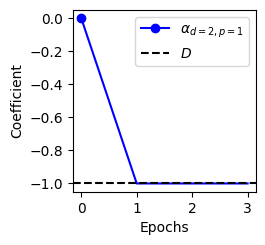

total number of terms: 9
4.196643033083092e-14


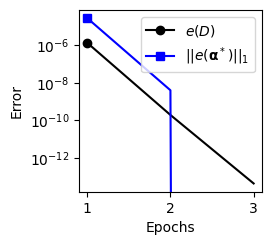

In [26]:
i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if ( d[0]==2 and p[0]==1 ):
            plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{d="+str(d[0])+", p="+str(p[0])+"}$", color="blue", marker="o", markevery=4)
            err_D = estimated_params[-1,i_pde,id,ip]
err_D = abs(err_D - D_ex)
plt.axhline(D_ex, linestyle = "--", color="black", label=r"$D$")
plt.legend()
plt.ylabel(r'Coefficient')
plt.xlabel('Epochs')
name = problem + "_" + "Dconv"
#plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)
plt.show()

i_pde = 0
err_other = np.zeros_like(estimated_params[:,0,0,0])
count = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if not ( d[0]==2 and p[0]==1 ):
            err_other += abs(estimated_params[:,i_pde,id,ip])
            count += 1

## coeff of u
i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==2 and p[0]==1:
            plt.plot(eps[1:], abs(estimated_params[1:,i_pde,id,ip]-D_ex),
                     label=r"$e(D)$", marker="o", markevery=4, color="black")
plt.plot(eps[1:], err_other[1:]/count, marker="s", markevery=4, color="blue", label=r"$||e(\mathbf{\alpha}^*)||_1$")
plt.yscale('log')
plt.ylabel(r'Error')
plt.xlabel('Epochs')
plt.legend()
name = problem + "_" + "D"
#plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

print("total number of terms: "+str(numPDE*len(ds)*len(ps)))
print((err_other[-1])+err_D)